In [ ]:
from google.colab import files

uploaded = files.upload()

Saving DCGAN.zip to DCGAN.zip


In [ ]:
import zipfile
import os

In [ ]:
with zipfile.ZipFile("/content/DCGAN.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")

In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders

In [ ]:
input_folder = '/content/data_faces'

In [ ]:
splitfolders.ratio(input_folder, output='/content/data', seed=42, 
                   ratio=(.7,.2, .1), group_prefix=None)

Copying files: 1289 files [00:00, 8929.19 files/s]


In [ ]:
splitfolders.fixed(input_folder, output='/content/data', seed=42, 
                   fixed=(35, 20), oversample=False, group_prefix=None)

Copying files: 1289 files [00:00, 6771.84 files/s]


In [ ]:
import numpy as np 
import pandas as pd 
import os

In [ ]:
import numpy as np
from collections import OrderedDict
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from functools import reduce
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 200
%config InlineBackend.figure_format = 'retina'
train_on_gpu = torch.cuda.is_available()

In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders

In [ ]:
input_folder='/content/data_faces'

In [ ]:
splitfolders.ratio(input_folder, output='/content/data', seed=42, 
                   ratio=(.7,.2, .1), group_prefix=None)

Copying files: 1289 files [00:00, 5544.18 files/s]


In [ ]:
splitfolders.fixed(input_folder, output='/content/data', seed=42, 
                   fixed=(35, 20), oversample=False, group_prefix=None)

Copying files: 1289 files [00:00, 5560.08 files/s]


In [ ]:
def DataConstructor2000(path_to_train, path_to_test, classes=None, num_workers=4, batch_size=12, valid_size = 0.2):
    
  
    # Transformations to the image, edit as need be
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize([224, 224]),
        transforms.ToTensor()])
    
    train_dataset = datasets.ImageFolder(path_to_train, transform=transform)
    print("Successfully Loaded Training Set.")

    test_dataset = datasets.ImageFolder(path_to_test, transform=transform)
    print("Successfully Loaded Test Set.")

    
    # obtain training indices that will be used for validation
    num_train = len(train_dataset)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                               sampler=train_sampler, num_workers=num_workers)

    valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                               sampler=valid_sampler, num_workers=num_workers)

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=6, 
        num_workers=num_workers, shuffle=True)
    if classes != None:
        print("Number of Classes:", len(classes))
    return train_loader, valid_loader, test_loader, classes

In [ ]:
train_loader, valid_loader,test_loader, classes = DataConstructor2000(path_to_train='/content/data/train',path_to_test='/content/data/test',
                                                                       classes=['Fake','Real'],num_workers=40, batch_size=16, valid_size = 0.3)

Successfully Loaded Training Set.
Successfully Loaded Test Set.
Number of Classes: 2


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(16, 3, 224, 224)


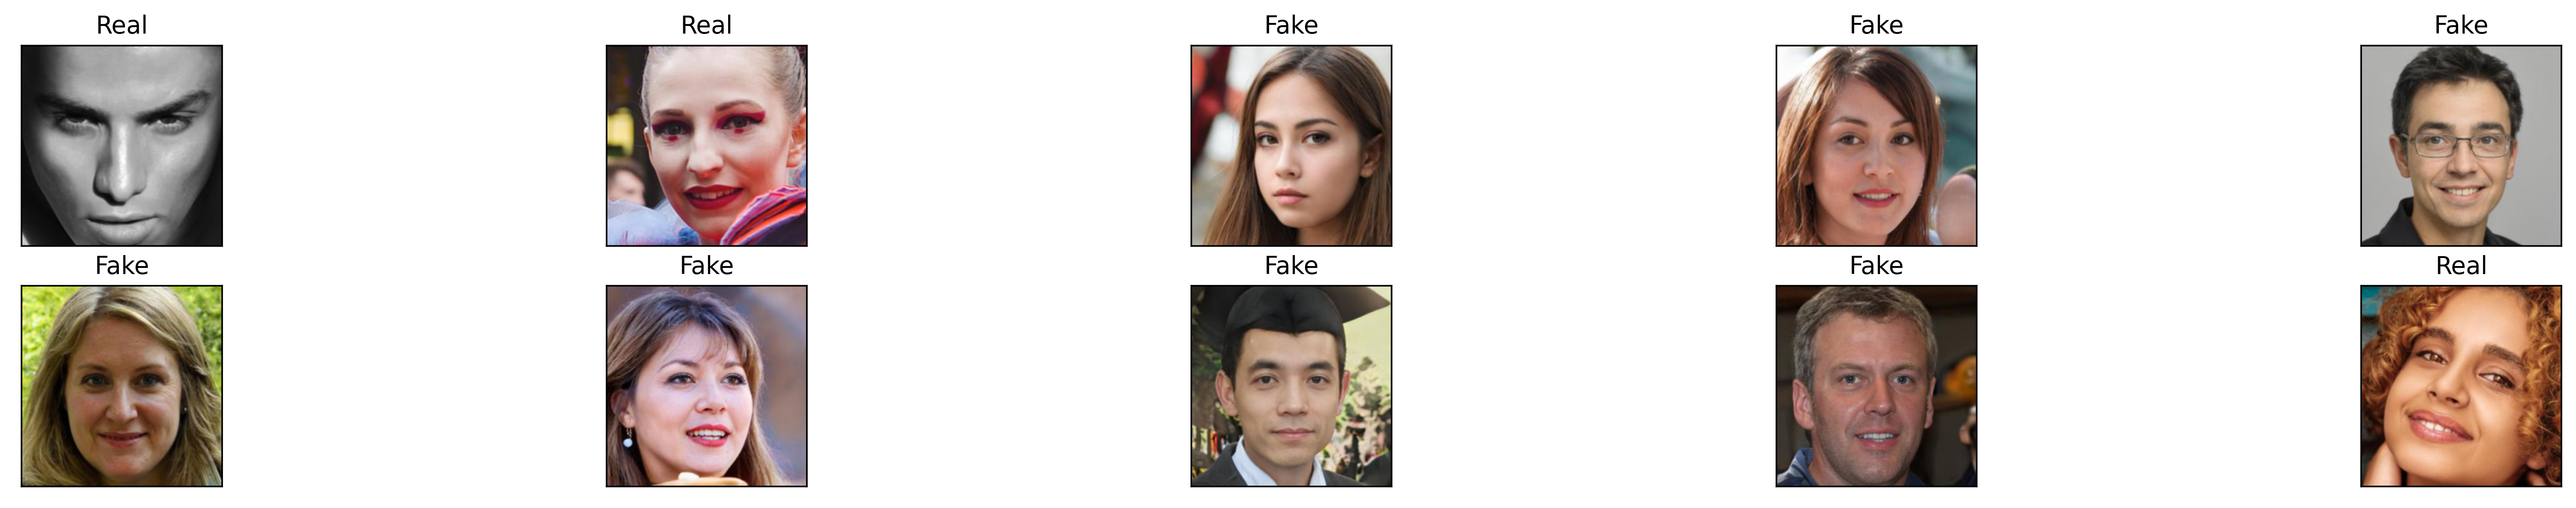

In [ ]:
# helper function to un-normalize and display an image
def imshow(img):
#     img = img / 2 + 0.5  # unnormalize if you added normalization in the transformation step
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
print(images.shape)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=True)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=True)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=True)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=True)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class FBResNet(nn.Module):

    def __init__(self, block, layers, num_classes=2):
        self.inplanes = 64
        # Special attributs
        self.input_space = None
        self.input_size = (299, 299, 3)
        self.mean = None
        self.std = None
        super(FBResNet, self).__init__()
        # Modules
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                                bias=True)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7)
        self.last_linear = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=True),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def features(self, input):
        x = self.conv1(input)
        self.conv1_input = x.clone()
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

    def logits(self, features):
        x = self.avgpool(features)
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

    def forward(self, input):
        x = self.features(input)
        x = self.logits(x)
        return x


def fbresnet18(num_classes=2):

    model = FBResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)
    return model


def fbresnet34(num_classes=2):

    model = FBResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes)
    return model


def fbresnet50(num_classes=2):

    model = FBResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes)
    return model


def fbresnet101(num_classes=2):

    model = FBResNet(Bottleneck, [3, 4, 23, 3], num_classes=num_classes)
    return model


def fbresnet152(num_classes=2):
    """Constructed a ResNet-152 model.
      pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = FBResNet(Bottleneck, [3, 8, 36, 3], num_classes=num_classes)

    return model.cuda()

In [ ]:
model = fbresnet152(num_classes=2)
model = nn.DataParallel(model)
# model

In [ ]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optimizer = torch.optim.SGD([
    {'params': list(model.parameters())[:-1], 'lr': 1e-3, 'momentum': 0.9, 'weight_decay': 1e-3},
    {'params': list(model.parameters())[-1], 'lr': 5e-5, 'momentum': 0.9, 'weight_decay': 1e-5}
])

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
# number of epochs to train the model
n_epochs = 40

valid_loss_min = np.Inf # track change in validation loss
training_vis = []
valid_vis = []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    training_vis.append(train_loss)
    valid_vis.append(valid_loss)
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('\nValidation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'ResNet35656_gan-detector_after82.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.579695 	Validation Loss: 2.868574

Validation loss decreased (inf --> 2.868574).  Saving model ...
Epoch: 2 	Training Loss: 0.722333 	Validation Loss: 0.225429

Validation loss decreased (2.868574 --> 0.225429).  Saving model ...
Epoch: 3 	Training Loss: 0.535409 	Validation Loss: 0.275439
Epoch: 4 	Training Loss: 0.612993 	Validation Loss: 0.223126

Validation loss decreased (0.225429 --> 0.223126).  Saving model ...
Epoch: 5 	Training Loss: 0.484290 	Validation Loss: 0.428254
Epoch: 6 	Training Loss: 0.540467 	Validation Loss: 0.278309
Epoch: 7 	Training Loss: 0.507272 	Validation Loss: 0.253552
Epoch: 8 	Training Loss: 0.484611 	Validation Loss: 0.234302
Epoch: 9 	Training Loss: 0.416155 	Validation Loss: 0.158861

Validation loss decreased (0.223126 --> 0.158861).  Saving model ...
Epoch: 10 	Training Loss: 0.376933 	Validation Loss: 0.270511
Epoch: 11 	Training Loss: 0.574380 	Validation Loss: 0.131527

Validation loss decreased (0.158861 --> 0.131527). 

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
model.load_state_dict(torch.load('ResNet35656_gan-detector_after82.pt'))

<All keys matched successfully>

In [ ]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
# iterate over test data
for data, target in test_loader:
#     print(target)
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
#     print(output)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
#     print(pred)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(2):
#         print(i)
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.067910

Test Accuracy of  Fake: 100% (27/27)
Test Accuracy of  Real: 100% (17/17)

Test Accuracy (Overall): 100% (44/44)


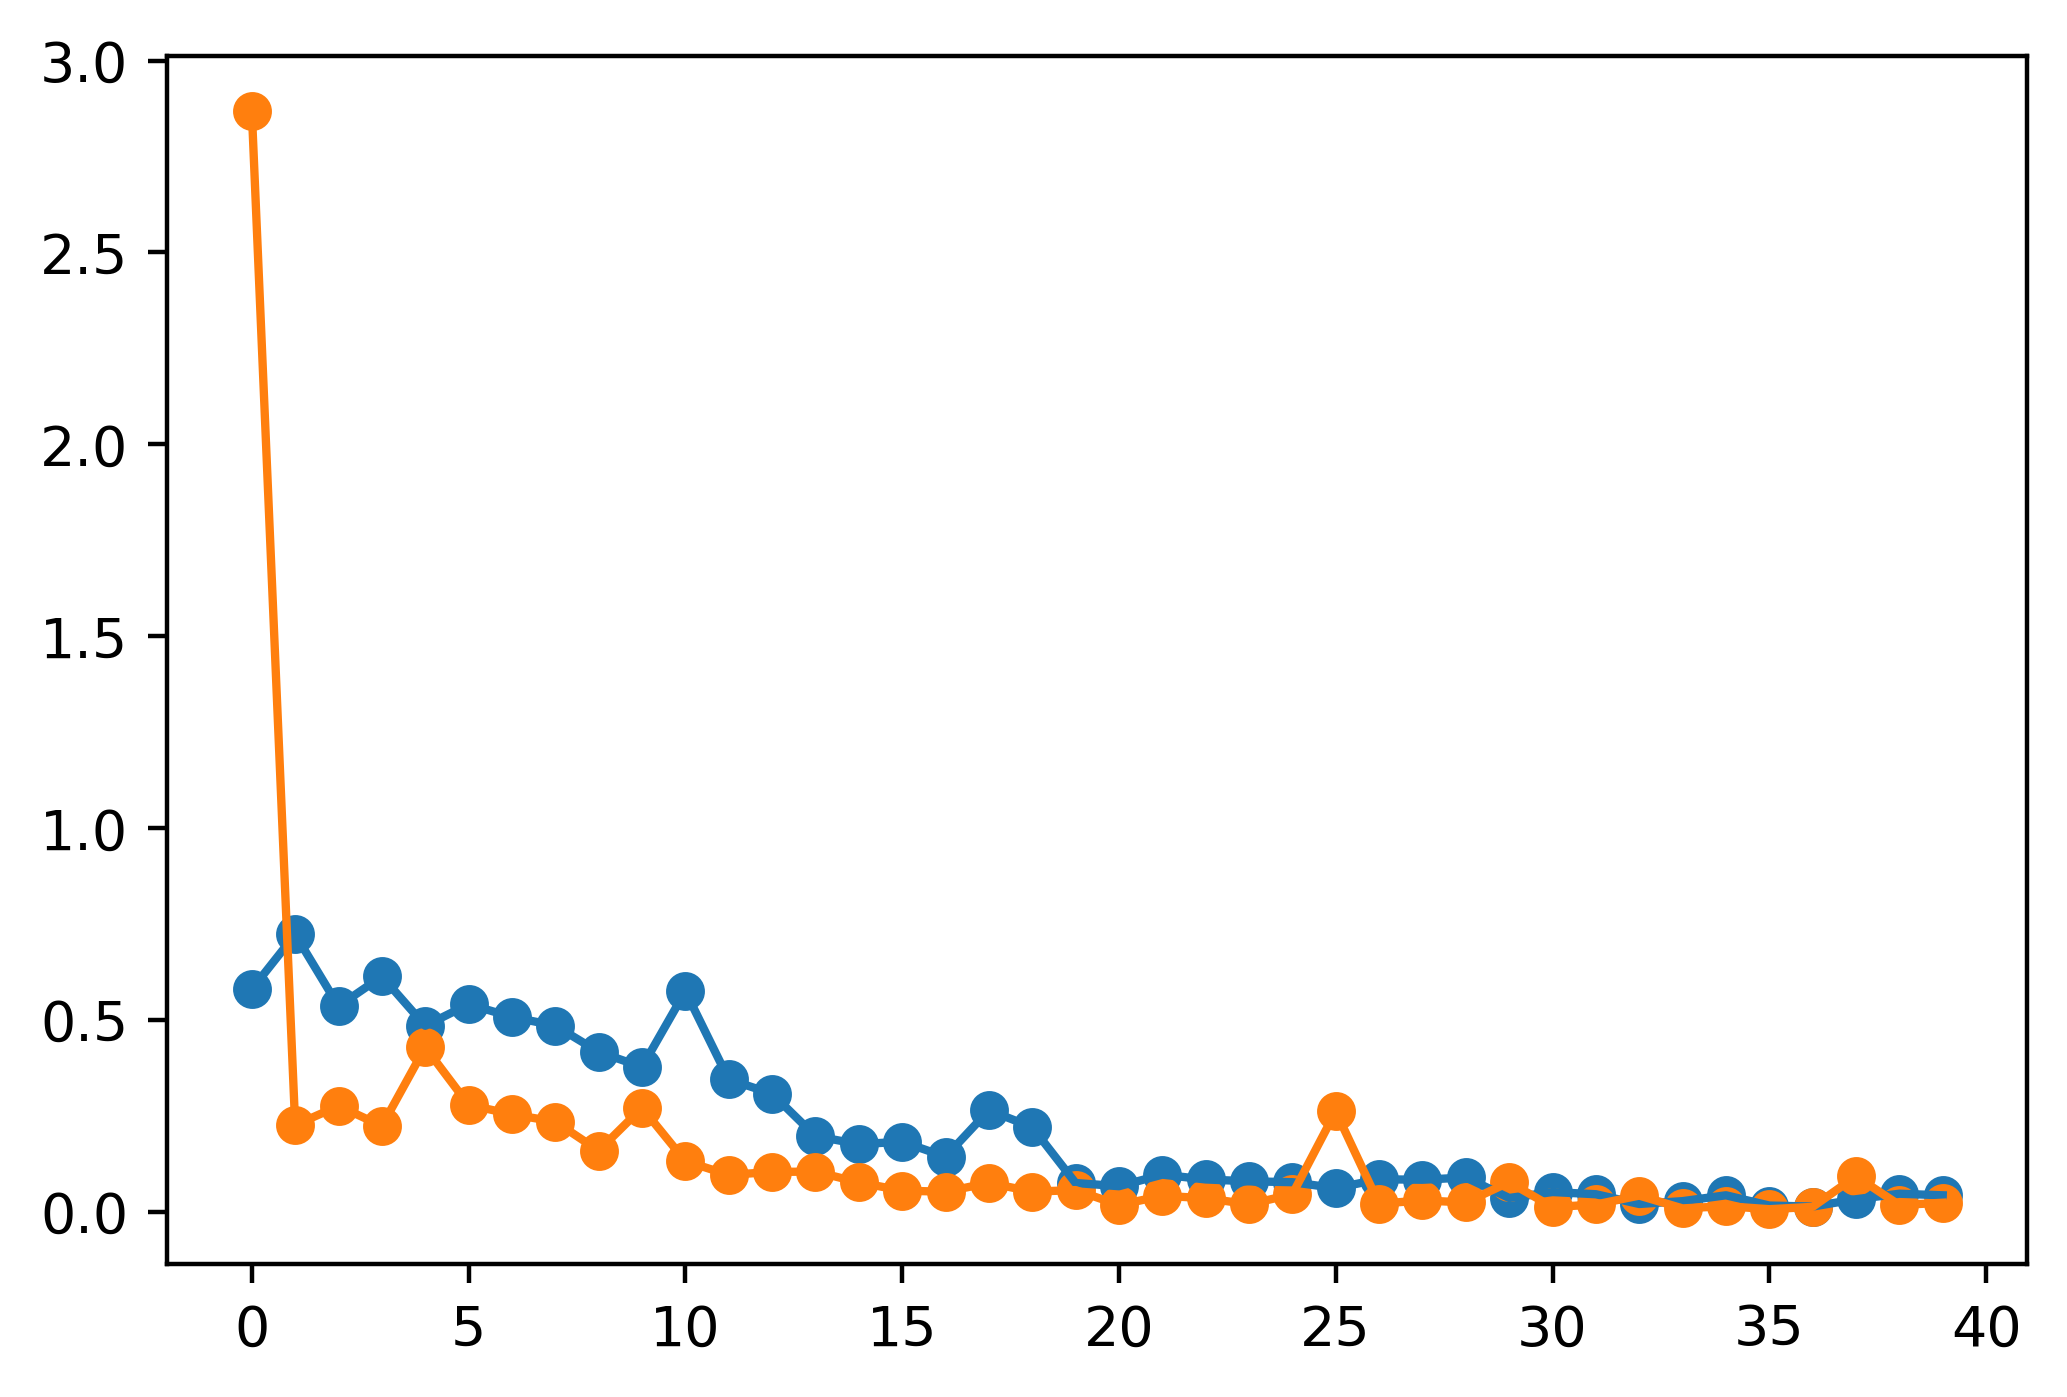

In [ ]:
plt.plot(range(epoch), training_vis)
plt.scatter(range(epoch), training_vis)
plt.scatter(range(epoch), valid_vis)
plt.plot(range(epoch), valid_vis)
plt.savefig('Resnet_77_scatter.svg')

In [ ]:
np.savetxt('Resnet_77.txt', np.array([training_vis, valid_vis]))

(6, 3, 224, 224)


IndexError: ignored

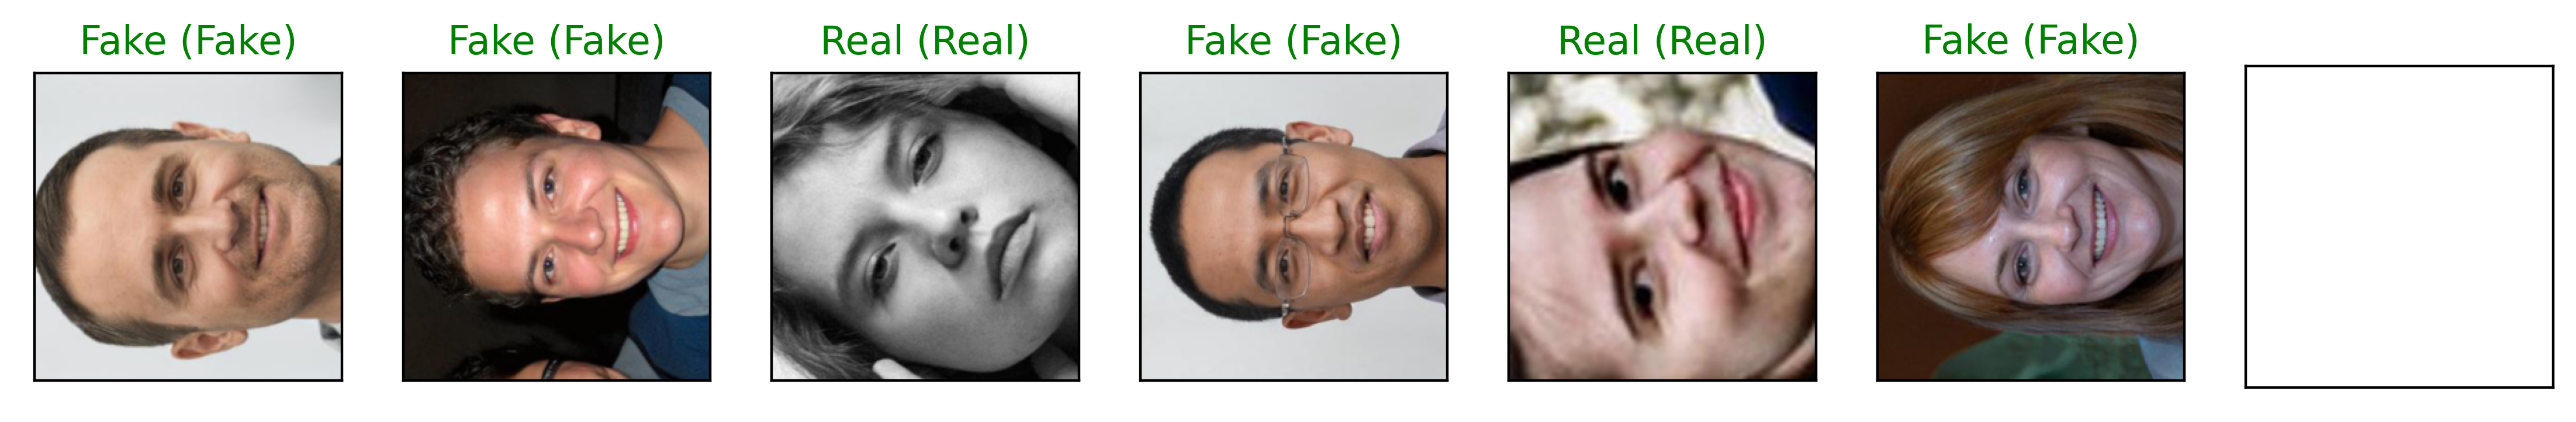

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()
labels = labels.numpy()
print(images.shape)
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(20, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.swapaxes((images[idx]),axis1=0, axis2=2))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if classes[preds[idx]]==classes[labels[idx]] else "red"))
plt.savefig('rESNET_miss.pdf')